<a href="https://colab.research.google.com/github/rnjsdn12332/GAN_study/blob/main/0705_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('./mount') #파일 접근을 위해 드라이브 마운트

Mounted at ./mount


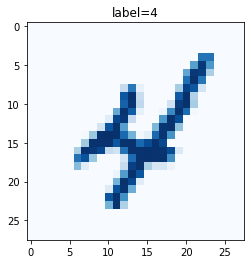

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import pandas
import matplotlib.pyplot as plt


from torch.utils.data import Dataset

class MnistDataset(Dataset) :

    def __init__(self, csv_file) :
        self.data_df=pandas.read_csv(csv_file, header=None)
        pass
    
    #데이터셋의 길이 반환
    def __len__(self) : 
        return len(self.data_df)

    #데이터셋의 n번째 아이템 반환
    def __getitem__(self, index) : 
        #이미지 목표(레이블)
        label=self.data_df.iloc[index, 0]
        target=torch.zeros((10))
        target[label]=1.0 #원핫인코딩

        #이미지 픽셀값을 담은 것을 0과 1사이 범위로 정규화
        image_values = torch.FloatTensor(self.data_df.iloc[index,1:].values) / 255.0
        return label, image_values, target
    
    def plot_image(self, index) :
        img=self.data_df.iloc[index, 1:].values.reshape(28,28)
        plt.title("label="+str(self.data_df.iloc[index, 0]))
        plt.imshow(img, interpolation = "none", cmap="Blues")
        

mnist_dataset=MnistDataset('mount/My Drive/Colab Notebooks/myo_gan/mnist_data/mnist_train.csv')
mnist_dataset.plot_image(9)

In [ ]:
#판별기 생성

class Discriminator(nn.Module) :

    def __init__(self) :
        super().__init__()

        #신경망 레이어 정의
        self.model=nn.Sequential(
            nn.Linear(784,200), #레이어 수정
            nn.Sigmoid(),
            nn.Linear(200,1),
            nn.Sigmoid()
        )

        #손실함수 설정
        self.loss_function=nn.MSELoss()

        #SGD옵티마이저 설정
        self.optimiser=torch.optim.SGD(self.parameters(), lr=0.01)

        #진행 측정을 위한 변수 초기화
        self.counter=0
        self.progress=[]

        pass
    def forward(self, inputs) :
        #모델 실행
        return self.model(inputs)
        
    def train(self, inputs, targets) :
        #신경망 출력 계산
        outputs=self.forward(inputs)
        
        loss=self.loss_function(outputs, targets)

        self.counter+=1
        if(self.counter % 10 == 0) :
            self.progress.append(loss.item())
            pass
        if(self.counter % 10000 == 0) :
            print("counter = ", self.counter)
            pass
        #기울기를 초기화하고 역전파 후 가중치 갱신
    
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

    def plot_progress(self) :
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0,1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))

In [ ]:

def generate_random(size):
    random_data = torch.rand(size)
    return random_data


In [ ]:
%%time

D=Discriminator()


for label, image_data_tensor, target_tensor in mnist_dataset : 

    #실제 데이터
    D.train(image_data_tensor, torch.FloatTensor([1.0]))

    #생성된 데이터
    D.train(generate_random(784), torch.FloatTensor([0.0]))


counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000


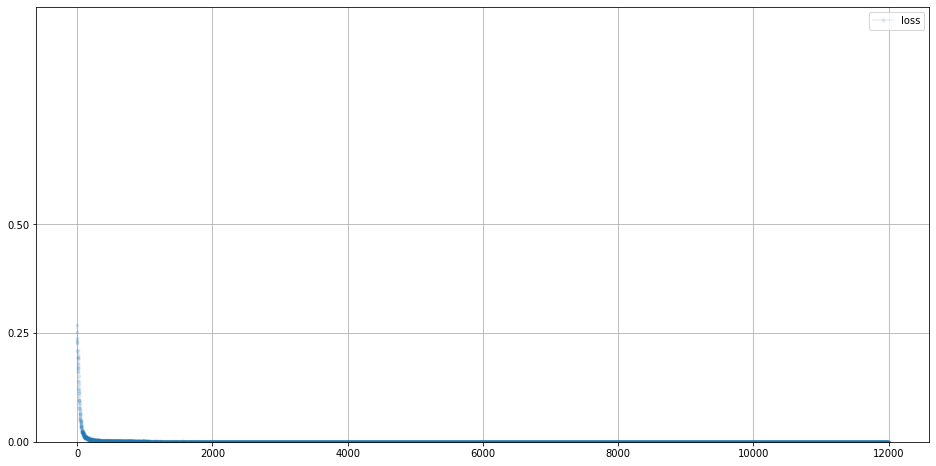

In [ ]:
D.plot_progress()

실제 이미지와 임의의 노이즈 이미지를 구별할 수 있음

In [ ]:
mnist_dataset[4][2]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])

In [ ]:
import random

for i in range(4):
  image_data_tensor = mnist_dataset[random.randint(0,60000)][1]
  print( D.forward( image_data_tensor ).item() )

for i in range(4):
  print( D.forward( generate_random(784) ).item() )


0.9977535605430603
0.995218813419342
0.9958971738815308
0.9984194040298462
0.0066649517975747585
0.006153828930109739
0.006639517843723297
0.005929255858063698


In [ ]:
# 생성기 생성

class Generator(nn.Module) : 
    def __init__(self) :
        
        super().__init__()

        #신경망 레이어 정의
        self.model=nn.Sequential(
            nn.Linear(1,200), #레이어 갯수 반대로
            nn.Sigmoid(),
            nn.Linear(200,784),
            nn.Sigmoid()
        )

        #SGD옵티마이저 설정
        self.optimiser=torch.optim.SGD(self.parameters(), lr=0.01)

        #손실함수 정의 삭제
        
        #진행 측정을 위한 변수 초기화
        self.counter=0
        self.progress=[]

        pass
    def forward(self, inputs) :
        #모델 실행
        return self.model(inputs)

    
    def train(self, D, inputs, targets) :
         
        #신경망 출력 계산
        g_output=self.forward(inputs)

        #판별기로 전달
        d_output = D.forward(g_output)

        
        #오차 계산
        loss=D.loss_function(d_output, targets)

        self.counter+=1
        if(self.counter % 10 == 0) :
            self.progress.append(loss.item())
            pass
    
        #기울기를 초기화하고 역전파 후 가중치 갱신

        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
        
    def plot_progress(self) :

        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0,1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))

    

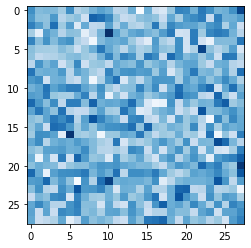

In [ ]:
G=Generator()
output = G.forward(generate_random(1))
img=output.detach().numpy().reshape(28,28)
plt.imshow(img, interpolation='none', cmap='Blues')



훈련하기 전의 생성기

In [ ]:
#GAN 훈련하기

D=Discriminator()
G=Generator()

for label, image_data_tensor, target_tensor in mnist_dataset : 
    
    #참에 대해 판별기 훈련
    D.train(image_data_tensor, torch.FloatTensor([1.0]))
    
    #거짓에 대해 판별기 훈련
    #G의 기울기가 계산되지 않도록 detach() 함수를 이용

    D.train(G.forward(generate_random(1).detach()), torch.FloatTensor([0.0]))
    
    #생성기 훈련
    G.train(D, generate_random(1), torch.FloatTensor([1.0]))

counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000


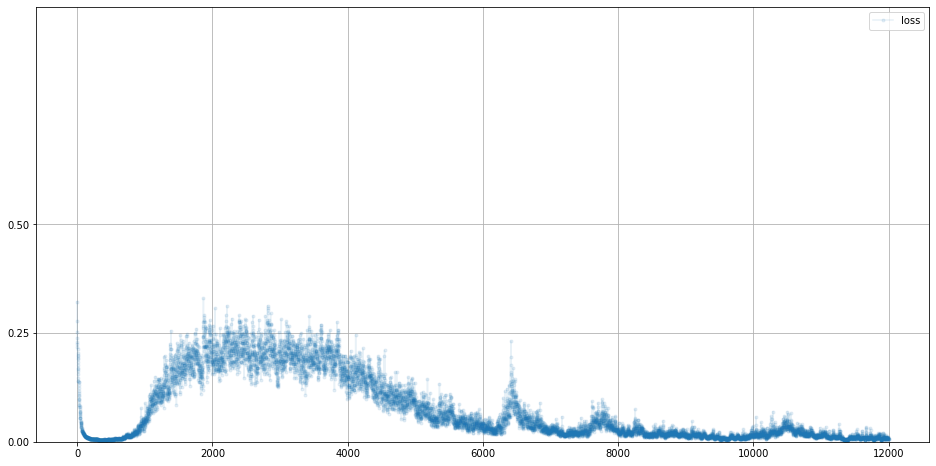

In [ ]:
D.plot_progress()

손실이 0으로 가까워졌고 한동안 이를 유지함 (판별기가 생성기를 앞선 시기)

손실값이 0.25 아래까지 올라감  (판별기와 생성기가 균형이 맞기 시작)

그러나 곧 손실값이 떨어짐

손실값이 0.25정도를 보이는게 판별기와 생성기의 성능이 균형을 이루는 것



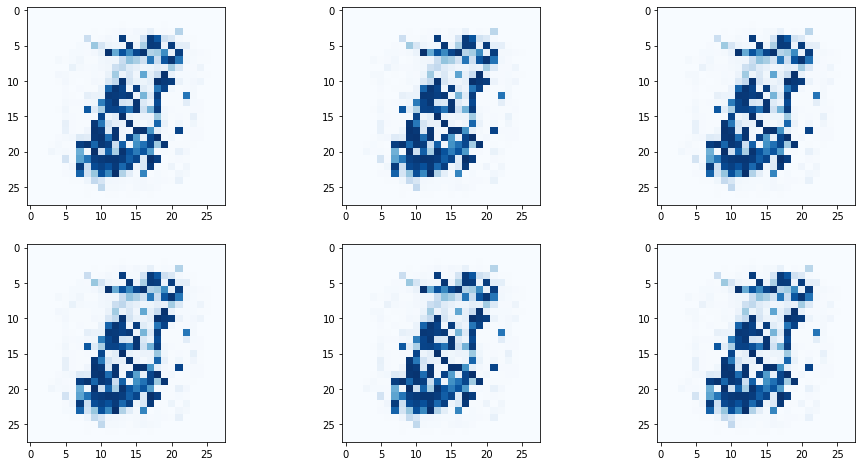

In [ ]:
#2행 3열로 생성된 이미지 출력

f, axarr = plt.subplots(2,3,figsize=(16,8))
for i in range(2) :
    for j in range(3) :
        output = G.forward(generate_random(1))
        img=output.detach().numpy().reshape(28,28)
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')
        

생성기를 통해 만든 이미지가 모두 똑같이 생김 (모드 붕괴)
생성기가 10개의 숫자를 다양하게 생성하는 것이 바람직하나 지금 생성기는 오직 하나만 만들게 되거나 선택지의 극히 일부만 만듬

왜? ->생성기가 판별기보다 더 앞서간 후 항상 실제에 가깝게 결과가 나오는 지점을 발견하여 그 이미지를 계속 만들어냄

해결 방법 :  판별기가 생성기에게 더 나은 피드백을 주게끔 훈련의 질을 높이기